In [11]:
import numpy as np # computing
from numpy import linalg as LA # linear algebra
from scipy.integrate import odeint # ordinary differential equations
from scipy.linalg import expm # matrix exponentiation
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots

t = np.arange(5000) # hr

# volume
v = np.array([600, 300, 3000, 6000]) # L

# "hollow" flow matrix. row = sink, column = source
Qh = np.array([[0,  2, 0, 6],
               [8,  0, 4, 0],
               [0, 10, 0, 2],
               [0,  0, 8, 0]]) # L/hr

# complete flow matrix. diagonal entries set so columns (axis = 0) sum to zero
Q = Qh - np.diag(Qh.sum(axis = 0)) # L/hr

# plot settings
sns.set(rc={"figure.dpi":200, 'savefig.dpi':300})

# initial concentration [PO4]
P0 = [3, 2, 4, 2] # umol/L

# default plot settings
def legend():
    plt.legend(title="Tank", labels=("A","B","C","D"))

# function to set structure of b
def bio(beta, A, B):
    return beta * np.array([-A, -B, B, A])

# fraction: what fraction of the surface nutrient 
# influx is diverted to depth?
fraction = .4

R = -105 # Redfield ratio: O2:PO4 in photosynthesis
c_eq = 350 # surface [O2] at atmospheric equilibrium (umol/L)
k_eq = 0.01 # atmospheric equilibration rate constant (/hr)

O0 = [200, 200, 200, 200] # Initial [O2] (umol/L)

# The Superproblem

The following models duplicate the problem as it was originally posed by Broecker and Peng (1982). They key difference is that the system is not closed; there is an external pump continually supplying water _of a set concentration,_ along with a drain to balance the system. Originally, the flow rates associated with those external components were provided. However, it is possible to calculte what they need to be to maintain constant volume in each tank, given the hollow matrix of internal flow rates like we saw previously. (Find the one term which changed, and check what those external flow rates have to be using print(qe). You can confirm that they match the original problem statement.) What new behaviors do you notice? The first model is purely physical circulation, the second incorporates both a biological pump and oxygen circulation. What does this model capture about the real ocean that our closed system may have missed? Hint: you will need to adjust the time interval...

[A, B, C, D] =  [2.35810811 2.36896723 2.38778406 2.42088045]


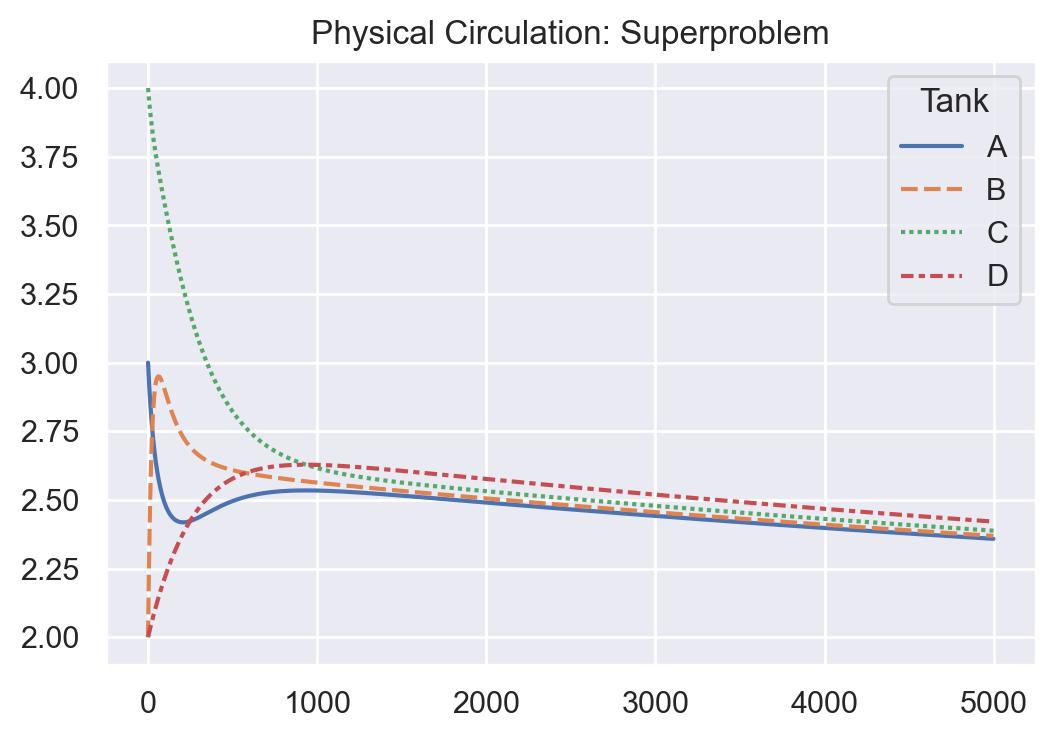

In [8]:
Qhs = np.array([[0,  2, 0, 5], # s for "superproblem" (L/hr)
                [8,  0, 4, 0],
                [0, 10, 0, 2],
                [0,  0, 8, 0]])

qe = Qhs.sum(axis = 0) - Qhs.sum(axis = 1) # external flow rates needed to maintain volume
qi, qo = np.mean([[qe, np.abs(qe)], [qe, -np.abs(qe)]], axis = 1)

Qs = Qhs - np.diag(Qhs.sum(axis = 0)) + np.diag(qo) # L/hr

ci = 2 # external inflow [PO4] (umol/L)

def sys_super(c, t):
    return (Qs @ c + qi * ci) / v

sol_super = odeint(sys_super, P0, t)

sns.lineplot(data=sol_super).set(title="Physical Circulation: Superproblem")
legend()

print("[A, B, C, D] = ", sol_super[-1])

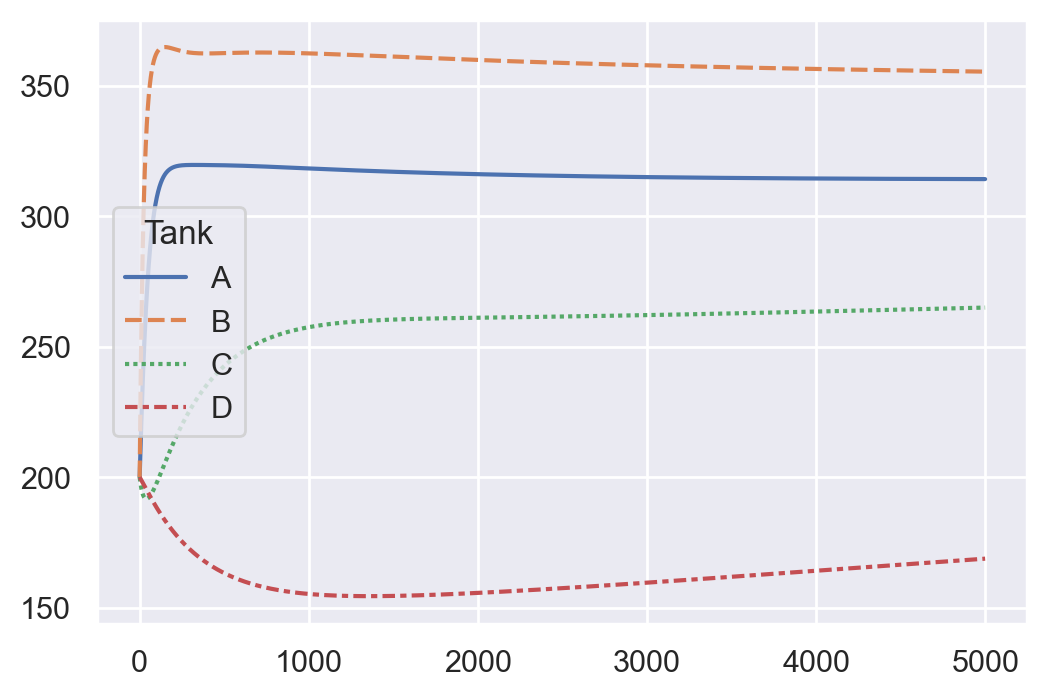

In [12]:
def sys_super_oxy(c, t):
    b = bio(fraction, *(Qh[:2] @ c[:4]))
    r = k_eq * np.array([c_eq - c[4], c_eq - c[5], 0, 0])
    return np.append((Qs @ c[:4] + qi * ci + b) / v,
                     (Qs @ c[4:] + qi * ci + R * b) / v + r)

sol_super_oxy = odeint(sys_super_oxy, np.append(P0, O0), t)

sol_super_oxy_title = "Coupled O$_2$ Superproblem: $\mathbf{b} \propto$Surface PO$_4^{3-}$ Influx"

sns.lineplot(data=sol_super_oxy[:,4:])
legend()

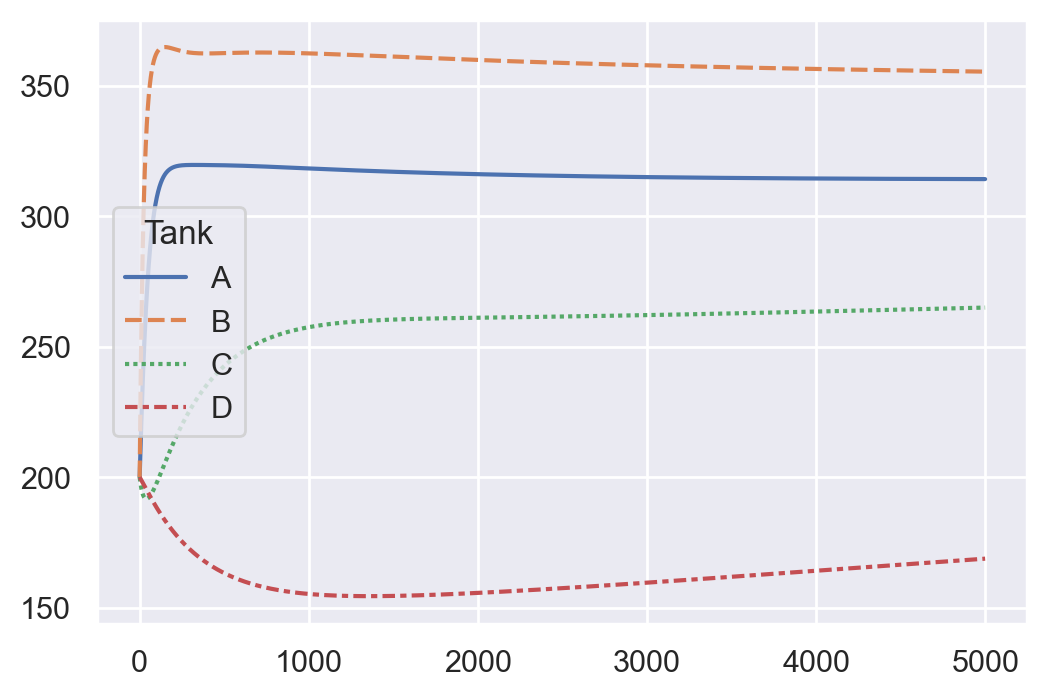

In [ ]:
sns.lineplot(data=sol_super_oxy[:,:4])
legend()